<a href="https://colab.research.google.com/github/pouvelenc/DD2365-aflum/blob/main/adaptive_mesh_refinement_turb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DD2365 - Project**
## **Adaptive algorithm for NS with slip-with-friction BCs**
**Povel Kann**

## **Environment setup**

In [31]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-release-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

from matplotlib.animation import FuncAnimation

import matplotlib as mpl

from IPython.display import HTML

import logging

logging.getLogger('FFC').setLevel(logging.CRITICAL)
logging.getLogger('UFL').setLevel(logging.CRITICAL)
logging.getLogger('DOLFIN').setLevel(logging.CRITICAL)

### **Mesh**

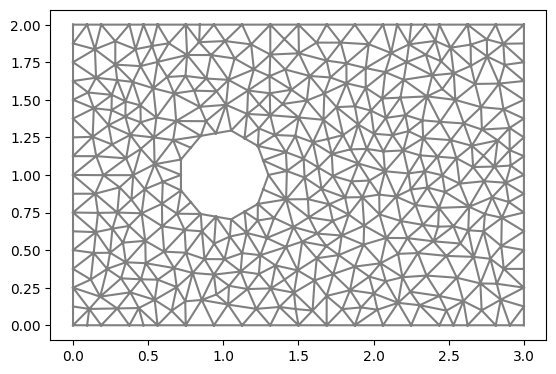

In [32]:
# define domain
length = 3
height = 2

# define circle
xc = 1
yc = 0.5*height
rc = 0.3

# define subdomains for boundary conditions
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], 0.0)

class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], length)

class Lower(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], 0.0)

class Upper(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[1], height)

class Skin_Friction(SubDomain):
    def inside(self, x, on_boundary):
        return (on_boundary and (not near(x[0], 0.0)) and (not near(x[0], length)) \
                and (not near(x[1], 0.0)) and (not near(x[1], height)))

left = Left()
right = Right()
lower = Lower()
upper = Upper()
skin_friction = Skin_Friction()

# generate mesh
resolution = 16
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(length,height)) - Circle(Point(xc,yc),rc), resolution)

plt.figure()
plot(mesh)
plt.show()

## **Code**

#### **Mesh refinement**

DEBUG:UFL_LEGACY:Blocks of each mode: 
  24	partial
DEBUG:UFL_LEGACY:Blocks of each mode: 

DEBUG:UFL_LEGACY:Blocks of each mode: 
  6	full
DEBUG:UFL_LEGACY:Blocks of each mode: 
  2	full
DEBUG:UFL_LEGACY:Blocks of each mode: 
  4	partial
DEBUG:UFL_LEGACY:Blocks of each mode: 
  2	full
DEBUG:UFL_LEGACY:Blocks of each mode: 
  1	full


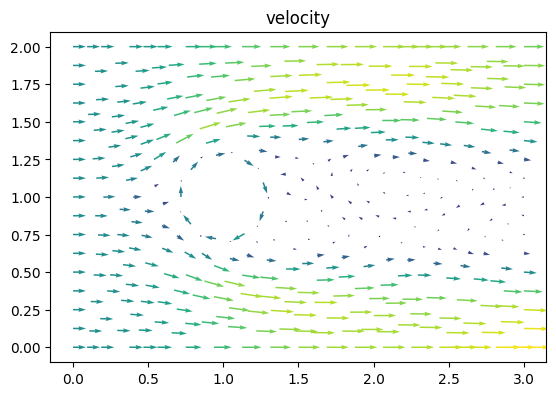

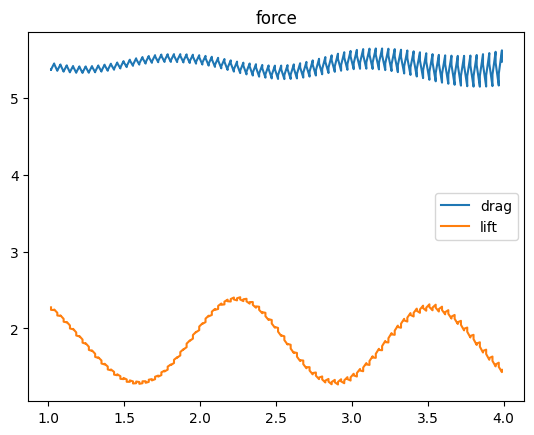

DEBUG:UFL_LEGACY:Blocks of each mode: 
  8	full
DEBUG:UFL_LEGACY:Blocks of each mode: 
  1	full


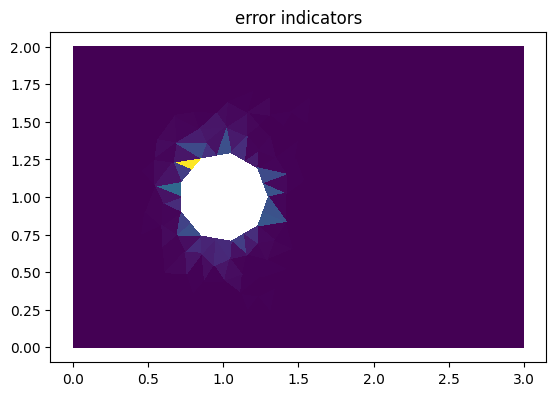

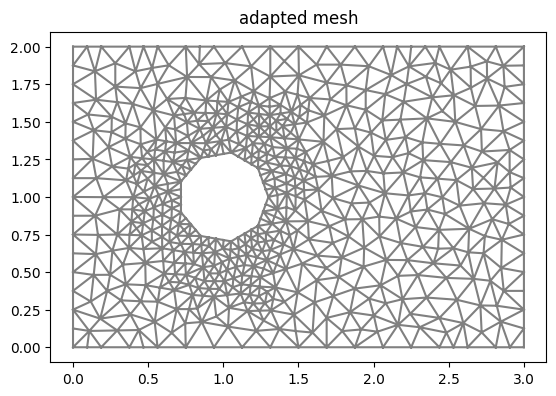

DEBUG:UFL_LEGACY:Blocks of each mode: 
  24	partial
DEBUG:UFL_LEGACY:Blocks of each mode: 

DEBUG:UFL_LEGACY:Blocks of each mode: 
  6	full
DEBUG:UFL_LEGACY:Blocks of each mode: 
  2	full
DEBUG:UFL_LEGACY:Blocks of each mode: 
  4	partial
DEBUG:UFL_LEGACY:Blocks of each mode: 
  2	full
DEBUG:UFL_LEGACY:Blocks of each mode: 
  1	full


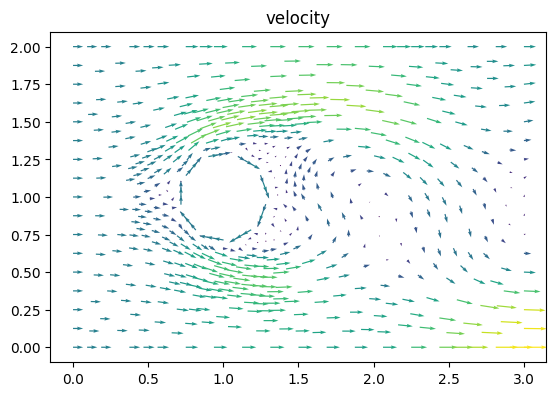

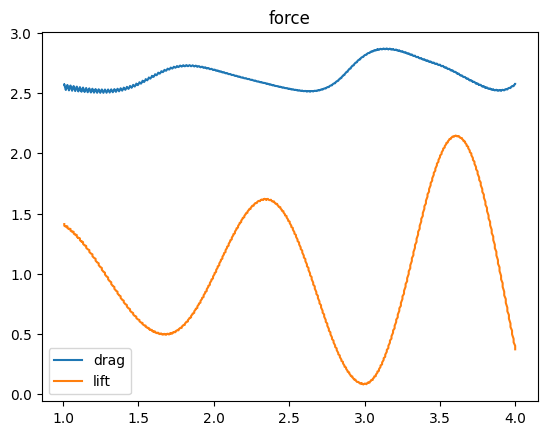

DEBUG:UFL_LEGACY:Blocks of each mode: 
  8	full


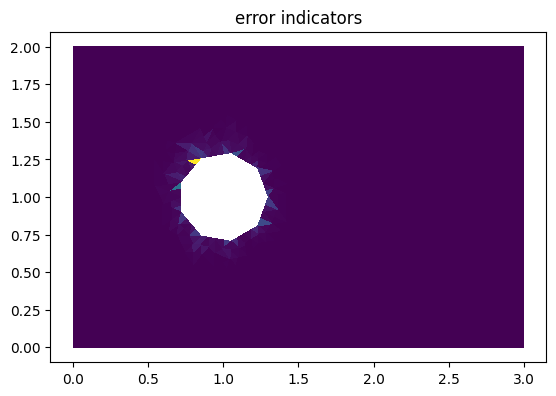

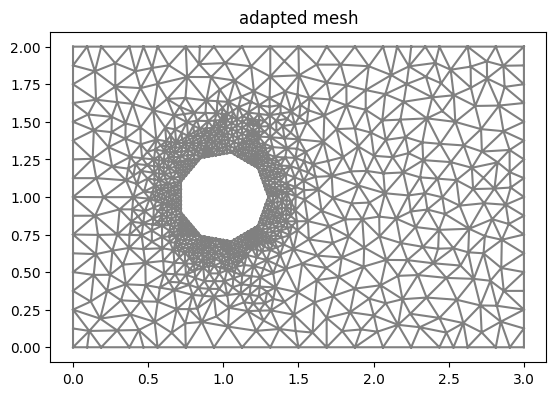

DEBUG:UFL_LEGACY:Blocks of each mode: 
  24	partial
DEBUG:UFL_LEGACY:Blocks of each mode: 

DEBUG:UFL_LEGACY:Blocks of each mode: 
  6	full
DEBUG:UFL_LEGACY:Blocks of each mode: 
  2	full
DEBUG:UFL_LEGACY:Blocks of each mode: 
  4	partial
DEBUG:UFL_LEGACY:Blocks of each mode: 
  2	full
DEBUG:UFL_LEGACY:Blocks of each mode: 
  1	full


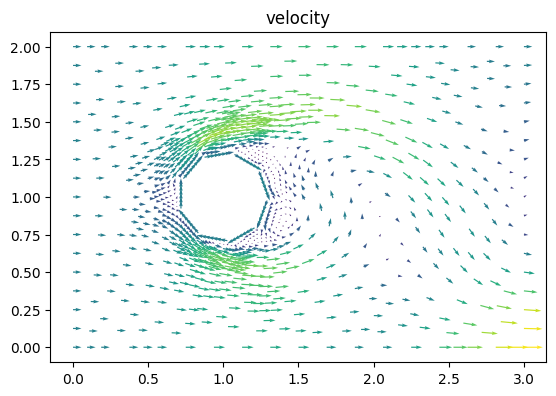

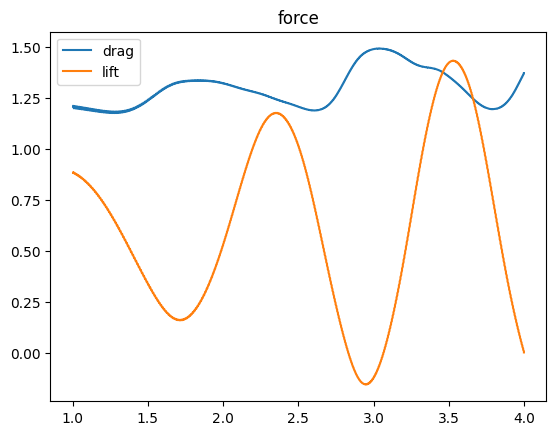

DEBUG:UFL_LEGACY:Blocks of each mode: 
  8	full


([(Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 505369), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 505535),
   Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 505369), FiniteElement('Lagrange', triangle, 1)), 505538)),
  (Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 505369), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 505655),
   Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 505369), FiniteElement('Lagrange', triangle, 1)), 505658)),
  (Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 505369), VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2)), 505775),
   Coefficient(FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 505369), FiniteElement('Lagrange', triangle, 1)), 505778)),
 

In [33]:
# viscosity
nu = 4.0e-3

def solve_NS(mesh):

    # define mesh functions for boundary conditions
    boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
    boundaries.set_all(0)
    left.mark(boundaries, 1)
    right.mark(boundaries, 2)
    lower.mark(boundaries, 3)
    upper.mark(boundaries, 4)
    skin_friction.mark(boundaries, 5)

    # finite element spaces (for velocity and pressure)
    V = VectorFunctionSpace(mesh, "Lagrange", 1)
    Q = FunctionSpace(mesh, "Lagrange", 1)

    # trial and test functions
    u = TrialFunction(V)
    p = TrialFunction(Q)
    v = TestFunction(V)
    q = TestFunction(Q)

    # boundary conditions
    class DirichletBoundaryLower(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0.0)

    class DirichletBoundaryUpper(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], height)

    class DirichletBoundaryLeft(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], 0.0)

    class DirichletBoundaryRight(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[0], length)

    class DirichletBoundaryObjects(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and (not near(x[0], 0.0)) and (not near(x[0], length)) and (not near(x[1], 0.0)) and (not near(x[1], height))

    dbc_lower = DirichletBoundaryLower()
    dbc_upper = DirichletBoundaryUpper()
    dbc_left = DirichletBoundaryLeft()
    dbc_right = DirichletBoundaryRight()
    dbc_objects = DirichletBoundaryObjects()

    # time dependent and stationary inflow conditions
    #uin = Expression('4.0*x[1]*(1-x[1])', element = V.sub(0).ufl_element())
    #uin = Expression('1.0 + 1.0*fabs(sin(t))', element = V.sub(0).ufl_element(), t=0.0)
    uin = 2.0
    bcu_in0 = DirichletBC(V.sub(0), uin, dbc_left)
    bcu_in1 = DirichletBC(V.sub(1), 0.0, dbc_left)
    bcu_upp0 = DirichletBC(V.sub(0), 0.0, dbc_upper)
    bcu_upp1 = DirichletBC(V.sub(1), 0.0, dbc_upper)
    bcu_low0 = DirichletBC(V.sub(0), 0.0, dbc_lower)
    bcu_low1 = DirichletBC(V.sub(1), 0.0, dbc_lower)
    bcu_obj0 = DirichletBC(V.sub(0), 0.0, dbc_objects)
    bcu_obj1 = DirichletBC(V.sub(1), 0.0, dbc_objects)

    pout = 0.0
    bcp1 = DirichletBC(Q, pout, dbc_right)

    #bcu = [bcu_in0, bcu_in1, bcu_upp0, bcu_upp1, bcu_low0, bcu_low1, bcu_obj0, bcu_obj1]
    #bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1, bcu_obj0, bcu_obj1]
    bcu = [bcu_in0, bcu_in1, bcu_upp1, bcu_low1]
    bcp = [bcp1]

    # measure for boundary integration
    ds = Measure('ds', domain=mesh, subdomain_data=boundaries)

    # iteration functions
    # (u0,p0) solution from previous time step
    # (u1,p1) linearized solution at present time step
    u0 = Function(V)
    u1 = Function(V)
    p0 = Function(Q)
    p1 = Function(Q)

    # parameters for nonlinear and lienar solvers
    num_nnlin_iter = 5
    prec = "amg" if has_krylov_solver_preconditioner("amg") else "default"

    # time step length
    dt = 0.2*mesh.hmin()


    # variational problem

    # stabilization parameters
    h = CellDiameter(mesh);
    u_mag = sqrt(dot(u1,u1))
    d1 = 4.0/sqrt((pow(1.0/dt,2.0) + pow(u_mag/h,2.0)))
    d2 = 2.0*h*u_mag

    # slip-with-friction boundary conditions, implemented as penalty terms
    e_n = FacetNormal(mesh)
    e_t = as_vector([e_n[1], -e_n[0]])
    C_alpha = 1.0e2
    alpha = C_alpha/h
    omega = 1.0
    beta = 8

    # angular (tangential) velocity
    u_t = -2.0

    # smagorinsky model (simplified)
    C_t = 1.0e-2

    # mean velocities for trapozoidal time stepping
    um = 0.5*(u + u0)
    um1 = 0.5*(u1 + u0)

    # momentum variational equation on residual form
    Fu = inner((u - u0)/dt + grad(um)*um1, v)*dx \
        - p1*div(v)*dx \
        + nu*inner(grad(um), grad(v))*dx \
        + C_t*h*h*sqrt(inner(grad(um1), grad(um1)))*inner(grad(um), grad(v))*dx \
        + d1*inner((u - u0)/dt + grad(um)*um1 + grad(p1), grad(v)*um1)*dx \
        + d2*div(um)*div(v)*dx \
        + alpha*(inner(dot(um,e_n), dot(v,e_n)))*ds(5) \
        + beta*(inner(dot(um,e_t) - u_t, dot(v,e_t)))*ds(5)

    au = lhs(Fu)
    Lu = rhs(Fu)

    # continuity variational equation on residual form
    Fp = d1*inner((u1 - u0)/dt + grad(um1)*um1 + grad(p), grad(q))*dx + div(um1)*q*dx
    ap = lhs(Fp)
    Lp = rhs(Fp)


    # define the direction of the force to be computed
    phi_x_D = 1.0
    phi_y_D = 0.0
    phi_x_L = 0.0
    phi_y_L = 1.0

    psi_expression_D = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x_D, phi_y=phi_y_D, element = V.ufl_element())
    psi_D = interpolate(psi_expression_D, V)

    psi_expression_L = Expression(("near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_x : 0.","near(pow(x[0]-xc,2.0) + pow(x[1]-yc,2.0) - pow(rc,2.0), 0.0) ? phi_y : 0."), xc=xc, yc=yc, rc=rc, phi_x=phi_x_L, phi_y=phi_y_L, element = V.ufl_element())
    psi_L = interpolate(psi_expression_L, V)

    Force_D = inner((u1 - u0)/dt + grad(um1)*um1, psi_D)*dx - p1*div(psi_D)*dx + nu*inner(grad(um1), grad(psi_D))*dx
    Force_L = inner((u1 - u0)/dt + grad(um1)*um1, psi_L)*dx - p1*div(psi_L)*dx + nu*inner(grad(um1), grad(psi_L))*dx

    # force normalization
    D = 2*rc
    normalization = -2.0/D

    # force computation data
    force_array_D = np.array(0.0)
    force_array_D = np.delete(force_array_D, 0)
    force_array_L = np.array(0.0)
    force_array_L = np.delete(force_array_L, 0)
    time = np.array(0.0)
    time = np.delete(time, 0)
    start_sample_time = 1.0

    us = []
    ps = []

    # time stepping
    T = 4
    t = dt
    while t < T + DOLFIN_EPS:

        # solve non-linear problem
        k = 0
        while k < num_nnlin_iter:

            # assemble momentum matrix and vector
            Au = assemble(au)
            bu = assemble(Lu)

            # compute velocity solution
            [bc.apply(Au, bu) for bc in bcu]
            [bc.apply(u1.vector()) for bc in bcu]
            solve(Au, u1.vector(), bu, "bicgstab", "default")

            # assemble continuity matrix and vector
            Ap = assemble(ap)
            bp = assemble(Lp)

            # compute pressure solution
            [bc.apply(Ap, bp) for bc in bcp]
            [bc.apply(p1.vector()) for bc in bcp]
            solve(Ap, p1.vector(), bp, "bicgstab", prec)

            # force
            F_D = assemble(Force_D)
            F_L = assemble(Force_L)
            if (t > start_sample_time):
              force_array_D = np.append(force_array_D, normalization*F_D)
              force_array_L = np.append(force_array_L, normalization*F_L)
              time = np.append(time, t)

            k += 1

        # update time step
        us.append(Function(V))
        ps.append(Function(Q))
        us[-1].assign(u1)
        ps[-1].assign(p1)

        u0.assign(u1)
        p0.assign(p1)
        t += dt

    primal_solutions = [(us[i], ps[i]) for i in range(len(us))]


    # plot solution
    plt.figure()
    plot(u1, title="velocity")
    plt.show()

    plt.figure()
    plt.title("force")
    plt.plot(time, force_array_D, label="drag")
    plt.plot(time, force_array_L, label="lift")
    plt.legend()
    plt.show()


    # finite element spaces (for adjoint velocity and pressure)
    VEa = VectorElement("CG", mesh.ufl_cell(), 2)
    QEa = FiniteElement("CG", mesh.ufl_cell(), 1)
    WEa = VEa * QEa

    Wa = FunctionSpace(mesh, WEa)

    # adjoint trial and test functions
    wa = Function(Wa)
    (phi, theta) = TrialFunctions(Wa)
    (va, qa) = TestFunctions(Wa)

    adjoint_bcs = [DirichletBC(Wa.sub(0), (0, 0), boundaries, 1),
                  DirichletBC(Wa.sub(0), (0, 0), boundaries, 2),
                  DirichletBC(Wa.sub(0), (0, 0), boundaries, 3),
                  DirichletBC(Wa.sub(0), (0, 0), boundaries, 4)]

    adjoint_solutions = []
    wa_n = Function(Wa)

    for t_step in reversed(range(len(us))):
        u_n = us[t_step]
        p_n = ps[t_step]

        phi_n, theta_n = split(wa_n)

        a_adjoint = (
            inner(va/dt, phi)*dx
          + inner(dot(u_n, grad(va)), phi)*dx
          + inner(dot(va, grad(u_n)), phi)*dx
          + inner(div(phi), qa)*dx
          - inner(div(va), theta)*dx
          + nu*inner(grad(va), grad(phi))*dx
        )

        L_adjoint = inner(va, psi_L)*dx

        solve(a_adjoint == L_adjoint, wa, bcs=adjoint_bcs)
        adjoint_solutions.insert(0, wa.copy(deepcopy=True))
        wa_n.assign(wa)


    phi_adjoint = wa.split()[0]

    plt.figure()
    plot(phi_adjoint, title="adjoint velocity")
    plt.show()

    return primal_solutions, adjoint_solutions


def compute_error_indicators(primal_sols, adjoint_sols, mesh, dt, nu, C_h, C_k):
    WDG  = FunctionSpace(mesh, "DG", 0)
    err_ind = Function(WDG)
    err_ind.vector()[:] = 0.0
    h = CellDiameter(mesh)

    # integrate over time
    for t_step in range(1, len(primal_sols)):
        u, p = primal_sols[t_step]
        u0, _ = primal_sols[t_step - 1]

        phi, theta = adjoint_sols[t_step].split(deepcopy=True)
        phi0, theta0 = adjoint_sols[t_step - 1].split(deepcopy=True)

        R1 = (u - u0) / dt + dot(grad(u), u) + grad(p) - nu * div(grad(u))
        R2 = (nu / h) * sqrt(inner(grad(u), grad(u)))
        R3 = div(u)

        R1_norm = sqrt(inner(R1, R1))
        R2_norm = sqrt(inner(R2, R2))
        R3_norm = sqrt(inner(R3, R3))

        # time derivatives
        phi_dot = (phi - phi0) / dt
        phi_dot_norm = sqrt(inner(phi_dot, phi_dot))

        theta_dot = (theta - theta0) / dt
        theta_dot_norm = sqrt(inner(theta_dot, theta_dot))

        # spatial derivatives h^2|D^2()|
        grad_phi_norm = sqrt(inner(div(grad(phi)), div(grad(phi))))
        grad_theta_norm = sqrt(inner(div(grad(theta)), div(grad(theta))))

        e_D = ((R1_norm + R2_norm) * (C_h * h * h * grad_phi_norm + C_k * dt * phi_dot_norm)
              + R3_norm * (C_h * h * h * grad_theta_norm + C_k * dt * theta_dot_norm))

        # primal stabilization terms, replacing (v, q) with the dual solution (phi, theta)
        u_mag = sqrt(dot(u, u))
        d1 = 4.0 / sqrt((1.0 / dt)**2 + (u_mag / h)**2)
        d2 = 2.0 * h * u_mag

        e_M = abs(d1*inner((u - u0)/dt + grad(u)*u + grad(p), grad(phi)*u)
                  + d2*div(u)*div(phi))

        total_error_n = project((e_D + e_M) * dt, WDG)
        err_ind.vector()[:] += total_error_n.vector()[:]

    return err_ind


# time step length
dt = 0.2*mesh.hmin()

# error indicator parameters
C_h = 1/8.0
C_k = 1/2.0

for _ in range(2):

    primal_solutions, adjoint_solutions = solve_NS(mesh)

    # compute local error indicators over the cells of the mesh
    err_ind = compute_error_indicators(primal_solutions, adjoint_solutions, mesh, dt, nu, C_h, C_k)
    err_ind_abs = np.abs(err_ind.vector())
    err_ind_mean = err_ind_abs.sum()/err_ind.vector().size()

    # local mesh refinement (specified by a cell marker)
    cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
    for c in cells(mesh):
      cell_marker[c] = False
      local_error_cell = err_ind_abs[c.index()]
      if local_error_cell > err_ind_mean*0.3:
          cell_marker[c] = True
    mesh = refine(mesh, cell_marker)


    plt.figure()
    plot(err_ind)
    plt.title("error indicators")
    plt.show()

    plt.figure()
    plot(mesh)
    plt.title("adapted mesh")
    plt.show()

primal_solutions, adjoint_solutions = solve_NS(mesh)

solutions = primal_solutions.split()[0]

fps = len(solutions)/4

"""
fig, ax = plt.subplots()
def animate(i):
    ax.clear()
    mesh.coordinates()[:] = coords[i]
    plot(solutions[i], axes=ax, title=f"t={frame_times[i]:.2f}")
ani = FuncAnimation(fig, animate,
                    frames=len(solutions),
                    interval=1000/fps)
HTML(ani.to_jshtml(fps=fps))
"""